# Exercise 7: Thresholding

https://docs.opencv.org/4.5.1/d7/d4d/tutorial_py_thresholding.html

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

In this exercise you will learn:
- *Simple thresholding* using the OpenCV function `cv.threshold()`.
- *Adaptive thresholding* using the OpenCV function `cv.adaptiveThreshold()`.
- *Otsu's thresholding*, which also uses the OpenCV function `cv.threshold()`.
- *Hysteresis thresholding*.

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Simple thresholding

<p>

<img width="300" height="200" src="../notebook_images/thresholding.png" style="padding: 10px; float: right;">

In simple thresholding, the matter is straight-forward. First we choose a threshold value $T$ for the pixel intensity, e.g. 127. Then, for every pixel $I(x,y)$, the same threshold value $T$ is used to *classify* each pixel into one of two *classes*. If the pixel value is bigger than the threshold $I(x,y) > T$, it is set to a maximum value $maxval$, e.g. $255$, but if the pixel value is smaller or equal to the threshold $I(x,y) \leq T$, it is set to $0$ (this is in fact one type of thresholding called *binary thresholding*):

$$
I(x,y) = 
\begin{cases}
    maxval, & \text{if} \; I(x,y) > T\\
    \;\;\;\;\;\;\;\;\;\;0, & \text{if} \; I(x,y)\leq T
\end{cases}
$$

The function `cv.threshold()` is used to apply the thresholding.

`cv.threshold(src, thresh, maxval, type) -> retval, dst`
- `src` is the source image, which should be a *grayscale image*.
- `thresh` is the threshold value $T$ which is used to *classify* the pixel values.
- `maxval` is the maximum value, e.g. 255, which is assigned to pixel values exceeding the threshold $T$.
- `type` is the [type of thresholding](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576) carried out:
  - `cv.THRESH_BINARY` is binary thresholding (as described above), where pixels are set to `0` or `maxval` (e.g. 255).
  - `cv.THRESH_BINARY_INV` is inverse binary thresholding, i.e. binary thresholding but with `0` and `maxval` exchanged.
  - `cv.THRESH_TRUNC` is truncated thresholding, i.e. binary thresholding, but where `0` is exchanged for the pixel's value.
  - `cv.THRESH_TOZERO` is "threshold to zero", i.e. binary thresholding, but where `maxval` is exchanged for the pixel's value.
  - `cv.THRESH_TOZERO_INV` is "inverse threshold to zero", i.e. inverse binary thresholding, but `maxval` = pixel's value.

See [this link](https://docs.opencv.org/4.5.1/db/d8e/tutorial_threshold.html) for a more detailed explanation of the various thresholding types.

The method has two return values:
- `retval` is the threshold $T$ that was used.
- `dst` is the thresholded image.
</p>

Let's read in an image in grayscale format and compare the different simple thresholding types with each other.

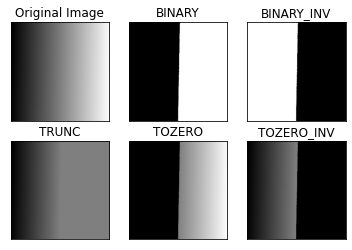

In [2]:
# Read in image in grayscale format
img = cv.imread('../data/gradient.png', 0)

# Threshold the image with T = 127 and maxval = 255
# using the various simple thresholding types
ret, thresh1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
ret, thresh2 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
ret, thresh3 = cv.threshold(img, 127, 255, cv.THRESH_TRUNC)
ret, thresh4 = cv.threshold(img, 127, 255, cv.THRESH_TOZERO)
ret, thresh5 = cv.threshold(img, 127, 255, cv.THRESH_TOZERO_INV)

# Plot the original image together with the various thresholded images
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1), plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])

plt.show()

Let's implement binary thresholding ourselves using numpy so that we understand the OpenCV function.

Our thresholding result is the same as OpenCV's: True


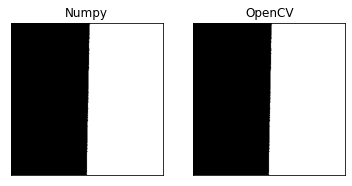

In [3]:
# Copy the image
thresh_bin = img.copy()

# Apply binary thresholding with T = 127 and maxval = 255
thresh_bin[thresh_bin > 127] = 255
thresh_bin[thresh_bin <= 127] = 0

# Make sure we get the same result as OpenCV's function
print(f"Our thresholding result is the same as OpenCV's: {np.all(thresh_bin == thresh1)}")

# Let's compare the two thresholded images by plotting them
plt.subplot(121), plt.imshow(thresh_bin, cmap="gray"), plt.title('Numpy'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(thresh1, cmap="gray"), plt.title('OpenCV'), plt.xticks([]), plt.yticks([]);

Let's also implement inverse binary threshold ourselves using numpy and compare it to OpenCV's implementation.

Our thresholding result is the same as OpenCV's: True


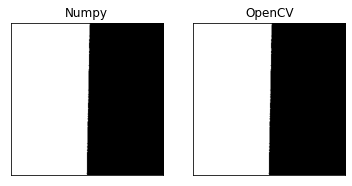

In [4]:
# Copy the image
thresh_bin_inv = img.copy()

# Apply inverse binary thresholding with T = 127 and maxval = 255
thresh_bin_inv[thresh_bin_inv <= 127] = 1
thresh_bin_inv[thresh_bin_inv > 127] = 0
thresh_bin_inv[thresh_bin_inv == 1] = 255

# Make sure we get the same result as OpenCV's function
print(f"Our thresholding result is the same as OpenCV's: {np.all(thresh_bin_inv == thresh2)}")

# Let's compare the two thresholded images by plotting them
plt.subplot(121), plt.imshow(thresh_bin_inv, cmap="gray"), plt.title('Numpy'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(thresh2, cmap="gray"), plt.title('OpenCV'), plt.xticks([]), plt.yticks([]);

## Adaptive thresholding

<p>

<img width="400" height="210" src="../notebook_images/thresholding_mean_kernel.png" style="padding: 10px; float: right;">

In the previous section, we used one global value (127) as a threshold. But this might not be good in all cases, e.g. if an image has different lighting conditions in different areas. In that case, *adaptive thresholding* can help. Here, the algorithm determines the threshold for a pixel based on a small region around it. For example, in the figure to the right, a 3x3 neighborhood region is used to calculate the mean value of 3x3 pixels. This is the threshold value used to compare the center pixel's value with. We can use different thresholds for different regions of the same image which gives better results for images with varying illumination.

The *mean* neighborhood region used in the example is called a *mean kernel* since it calculates a mean value, where each pixel in the region is weighted equally. But we can also use a kernel that weights each pixel differently, e.g. a Gaussian kernel (which uses a smaller weight for pixels further from the center pixel). We can also subtract a small constant $C$ from the calculated value. For the actual thresholding, binary och inverse binary thresholding is normally used.

The OpenCV function `cv.adaptiveThreshold()` is used for adaptive thesholding.

`adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst]) -> dst`
- `src` is the source (input) 8-bit single-channel image.
- `maxValue` is a non-zero value assigned to the pixels for which the threshold condition is satisfied.
- `adaptiveMethod` decides which [algorithm](https://docs.opencv.org/4.5.1/d7/d1b/group__imgproc__misc.html#gaa42a3e6ef26247da787bf34030ed772c) is used to calculate the threshold value.
  - `cv.ADAPTIVE_THRESH_MEAN_C`: the threshold value is the mean of the neighbourhood region minus the constant `C`.
  - `cv.ADAPTIVE_THRESH_GAUSSIAN_C`: the threshold value is a gaussian-weighted sum of the neighbourhood values minus `C`.
- `thresholdType` is the thresholding type, that must be either `cv.THRESH_BINARY` or `cv.THRESH_BINARY_INV`.
- `blockSize` determines the size of the neighborhood region used to calculate a threshold value for a pixel: 3, 5, 7, etc.
- `C` is a constant that is subtracted from the mean or weighted sum of the neighbourhood pixels.

The function returns one value `dst`, which is the thresholded image.
</p>

The code below compares global thresholding and adaptive thresholding for an image with varying illumination:

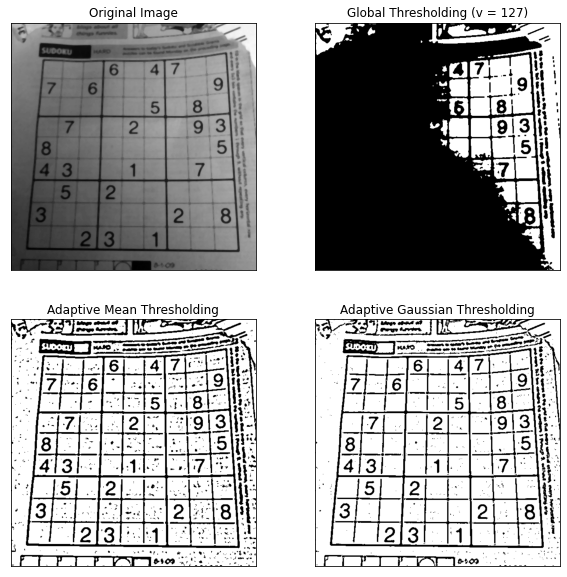

In [5]:
# Read an image as a grayscale image.
img = cv.imread('../data/sudoku.png', 0)

# Blur the image using a 5x5 median kernel, where the
# calculated median value is assigned to the center pixel.
# Bluring is normally used to remove noise in an image.
img = cv.medianBlur(img, 5)

# Let's use simple (global) binary thresholding as a benchmark for the adaptive methods.
# Here we are using a threshold T = 127, maxVal = 255 and binary thresholding.
ret, th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

# Apply adaptive (local) thresholding using a mean kernel.
# Here we are using maxVal = 255, binary thresholding, a 11x11 kernel and C = 2.
th2 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)

# Let's also apply adaptive (local) thresholding using a Gaussian kernel.
# Here we are also using maxVal = 255, binary thresholding, a 11x11 kernel and C = 2.
th3 = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

# Plot the results of the three thresholding methods.
plt.figure(figsize=(10,10))

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

## Otsu's Binarization

<p>

<img width="300" height="200" src="../notebook_images/thresholding.png" style="padding: 10px; float: right;">

In simple (global) thresholding, we used an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and determines it automatically.

Consider an image with only two distinct image values (bimodal image), where the histogram would only consist of two peaks. A good threshold would be in the middle of those two values. Similarly, Otsu's method determines an optimal global threshold value from the image histogram.

In order to do so, the `cv.threshold()` function (the same function we used for simple thresholding above) is used, where `cv.THRESH_OTSU` is passed in as an extra [thresholding type](https://docs.opencv.org/4.5.1/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a95251923e8e22f368ffa86ba8bce87ff) `type`.

`cv.threshold(src, thresh, maxval, type) -> retval, dst`

The threshold value `thresh` can be chosen arbitrary when `cv.THRESH_OTSU` is passed in as an extra thresholding type `type`, since the algorithm will find the optimal threshold value itself which is returned as the functions first return value `retval`.
</p>

---

Consider the example below. The input image is a noisy image. In the first case, simple (global) binary thresholding, i.e. `type = cv.THRESH_BINARY`, with a threshold value of 127 is applied. In the second case, Otsu's thresholding algorithm is applied together with binary thresholding, i.e. `type = cv.THRESH_BINARY + cv.THRESH_OTSU`. In the third case, the image is first filtered with a 5x5 gaussian kernel to remove the noise, then Otsu's thresholding algorithm is applied together with binary thresholding, i.e. `type = cv.THRESH_BINARY + cv.THRESH_OTSU`. The three thresholding results are then plotted next to each other.

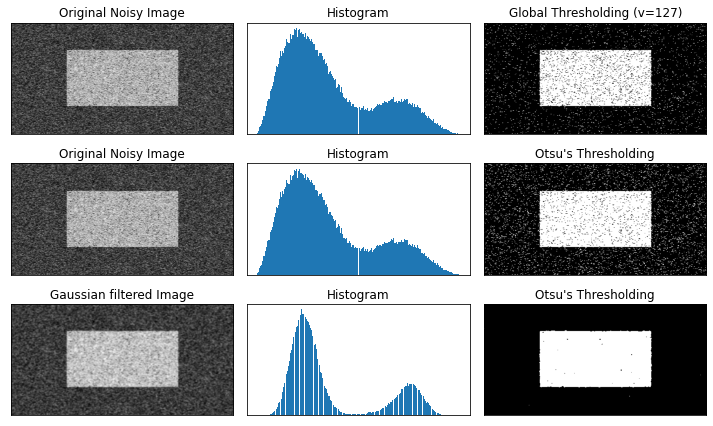

In [6]:
# Read an image as a grayscale image
img = cv.imread('../data/noisy2.png', 0)

# Apply simple (global) thresholding
ret1, th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

# Otsu's thresholding algorithm (with binary thresholding)
ret2, th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Blur the image using a 5x5 Gaussian kernel, with a standard
# deviation calculated from the kernel size (that's what the
# last input argument of 0 means), where the calculated weighted
# sum is assigned to the center pixel.
blur = cv.GaussianBlur(img, (5,5), 0)

# Otsu's thresholding algorithm (with binary thresholding) after Gaussian filtering
ret3, th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Plot all the images and their histograms
plt.figure(figsize=(10,6))

images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1), plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(3,3,i*3+2), plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(3,3,i*3+3), plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

### How does Otsu's Binarization work?

<p>

<img width="400" height="300" src="../notebook_images/otsu.gif" style="padding: 10px; float: right;">

This section demonstrates a Python implementation of Otsu's binarization to show how it actually works.

Since we are working with bimodal images, Otsu's algorithm tries to find a threshold value $t$ that minimizes the weighted within-class variance $\sigma_{w}^{2}(t)$ given by the relation:

$$
\sigma_{w}^{2}(t) = q_1(t) \sigma_{1}^{2}(t) + q_2(t) \sigma_{2}^{2}(t)
$$

where

$$
q_1(t) = \sum_{i=1}^{t} P(i) \quad \& \quad q_2(t) = \sum_{i=t+1}^{I} P(i)\\

\mu_1(t) = \sum_{i=1}^{t} \frac{iP(i)}{q_1(t)} \quad \& \quad \mu_2(t) = \sum_{i=t+1}^{I} \frac{iP(i)}{q_2(t)}\\

\sigma_{1}^{2}(t) = \sum_{i=1}^{t} [i - \mu_1(t)]^2 \frac{P(i)}{q_1(t)} \quad \& \quad \sigma_{2}^{2}(t) = \sum_{i=t+1}^{I} [i - \mu_2(t)]^2 \frac{P(i)}{q_2(t)}
$$

Otsu's method finds a value of $t$ that lies in between two peaks, such that variances within both classes are minimal. In other words, Otsu's method calculates the variance of pixel values, weighted by the probability mass (normalized probability of pixel values), on each side of the threshold $t$, and adds them together, such that this sum is the smallest for a certain threshold value $t$ (i.e. for a certain bin index, or in this case, pixel intensity).

See also [this link](https://www.wikiwand.com/en/Otsu%27s_method) for a Matlab implementation.
</p>

---

Let's look at a Python implementation below.

Manually calculated threshold: thresh = 118
OpenCV's calculated threshold:    ret = 117.0


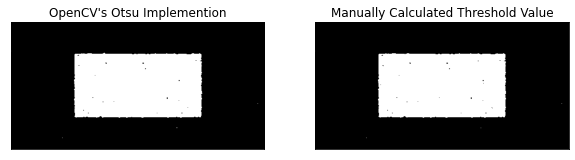

In [7]:
# Read an image as a grayscale image
img = cv.imread('../data/noisy2.png', 0)

# Blur the image using a 5x5 Gaussian kernel, with a standard
# deviation calculated from the kernel size (that's what the
# last input argument of 0 means), where the calculated weighted
# sum is assigned to the center pixel.
blur = cv.GaussianBlur(img, (5,5), 0)

# Find the normalized_histogram and its cumulative
# distribution function (CDF), called Q here
hist = cv.calcHist([blur], [0], None, [256], [0,256])
hist_norm = hist.ravel()/hist.sum()
Q = hist_norm.cumsum()

# "bins" is an array of values from 0 to 255,
# which is the same as pixel values in this case.
# We will iterate through each bin value in the "for" loop below
# to determine what bin value minimizes the weighted within-class variance.
bins = np.arange(256)

# These are the initial values of:
# - the weighted within-class variance (that we want to minimize in the "for" loop).
# - the corresponding threshold value that minimizes the weighted within-class variance.
fn_min = np.inf
thresh = -1

for i in range(1, 256):
    # PROBABILITIES (NORMALIZED PIXEL INTENSITIES)
    # Split the normalized histogram (i.e. containing
    # probabilities instead of counts) at bin "i".
    # p1 and p2 will each contain an array of probabilities
    # (i.e. the normalized count of pixel intensities in each bin).
    p1, p2 = np.hsplit(hist_norm, [i])
    
    # CUMSUM OF CLASSES (TOTAL PROBABILITY ON EACH SIDE OF THE THRESHOLD)
    # Calculate the probability on each side of the split point
    # (i.e. current bin "i") by using the normalized CDF (q1 + q2 = 1.0).
    q1, q2 = Q[i], Q[255] - Q[i]
    
    # If there is no probability mass on either side of the
    # split point "i", continue with the next interation
    # (i.e. next split point "i"), otherwise we will get
    # divide-by-zero errors when computing the means and
    # variances below.
    if q1 < 1.e-6 or q2 < 1.e-6:
        continue
    
    # BIN / PIXEL VALUES ON EACH SIDE OF THE THRESHOLD
    # Split the bins array at split point "i"
    # b1 and b2 will each contain an array of bin numbers,
    # which is the same as pixel values in this case.
    b1, b2 = np.hsplit(bins, [i])
    
    # Calculate the mean probability and variance 
    # accoring to the formula in the text above.
    # The bins (pixel intensities) are weighted by
    # their probability to calculate a mean pixel value.
    # This mean value is then used in the variance calculation.
    m1, m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1, v2 = np.sum(((b1-m1)**2)*p1)/q1, np.sum(((b2-m2)**2)*p2)/q2
    
    # Calculate the weighted within-class variance
    # accoring to the formula in the text above.
    # This is the value we want to minimize, i.e.
    # we want the variance of the pixel intensities,
    # weighted by the probability mass, on each side
    # of the split point (bin), added together, to be
    # as little as possible.
    fn = v1 * q1 + v2 * q2

    # Save the smallest weighted within-class variance
    # and corresponding threshold value seen so far.
    if fn < fn_min:
        fn_min = fn
        thresh = i

# Now, let's find Otsu's threshold value with OpenCV "cv.threshold" function
# so we can compare it with our own manual calculation above.
ret, otsu = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Let's compare OpenCV's calculation with our own
print(f"Manually calculated threshold: thresh = {thresh}\nOpenCV's calculated threshold:    ret = {ret}")

# Let's use our threshold value in OpenCV's "cv.threshold" function with a binary threshold
ret2, manual = cv.threshold(blur, thresh, 255, cv.THRESH_BINARY)

# Now, let's plot the image automatically thresholded by OpenCV's Otsu implementation,
# and the image thresholded using OpenCv's simple thresholding, but with our manually
# calculated threshold value.
plt.figure(figsize=(10,6))
plt.subplot(121), plt.imshow(otsu, cmap="gray")
plt.title("OpenCV's Otsu Implemention"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(manual, cmap="gray")
plt.title("Manually Calculated Threshold Value"), plt.xticks([]), plt.yticks([]);

## Hysteresis thresholding

<p>

<img width="400" height="300" src="../notebook_images/hysteresis.png" style="padding: 10px; float: right;">

Hysteresis is the lagging of an effect, i.e. a kind of inertia. In the context of thresholding, it means that areas above some low threshold are considered to be above the threshold (red in the figure) if they are also connected to areas above a higher, more stringent, threshold (blue in the figure). They can thus be seen as continuations of these high-confidence areas. Areas below the low threshold are considered noise. In the figure to the right, *double thresholding* means:
- **A** and **B** are considered as **strong** lines (or pixels) since they are above the high threshold.
- **C** and **E** are considered **weak** lines (or pixels) since they are between the two thresholds.
- **D** is considered as **noise** since it lies below the low threshold.

The hysteresis affects the lines (or pixels) above as follows:
- **C** is connected to a strong line (or pixels) **B**, i.e. it will be promoted to **strong**.
- **E** is not connected to a strong line (or pixels) **B**, i.e. it will be demoted to **noise**.

We will break hysteresis threasholding an image into two parts:

1. Double thresholding an image.
2. Applying a hysteresis to the  double thresholded image.

### Double threasholding

In double thresholding, we have two thresholds:
- The high threshold $T_{high}$ (e.g. 150).
- The low threshold $T_{low}$ (e.g. 50).

When we apply double thresholding to an image, we change the value of a pixel $I(x,y) as follows:

$$
I(x,y) = 
\begin{cases}
    strong, & \text{if} \; I(x,y) \geq T_{high}\\
    \;\;\;\;\;\;\;\;\;0, & \text{if} \; I(x,y) < T_{low}\\
    \;\;\;weak, & \text{otherwise}
\end{cases}
$$

where, normally, $strong = 255$ and $weak$ can be set arbitrarily but not to $0$ or $255$, i.e. $weak \notin \{0,255\}$.

### Applying a hysteresis

<img width="400" height="150" src="../notebook_images/hysteresis3.png" style="padding: 10px; float: right;">

The hysteresis part is applied after the double thesholding part above, i.e. all the pixels in the image either have the value $strong$ (e.g. 255), $0$ or $weak \notin \{0, 255\}$ (e.g. 100).

The hysteresis algorithm scans the image and, for each **weak** pixel, checks for any **strong** pixels in the direct neighbourhood (i.e. the closest pixel in all 8 directions). Then, the **weak** pixel is updated as follows:

$$
I(x,y) = 
\begin{cases}
    strong, & \text{if} \; I_{neighbour}(x',y') = strong\\
    \;\;\;\;\;\;\;\;\;0, & \text{otherwise}
\end{cases}
$$

We need to scan a copy of the double thresholded image in four *directions*:
- top-to-bottom, left-to-right
- top-to-bottom, right-to-left
- bottom-to-top, left-to-right
- bottom-to-top, right-to-left

The we add these four copied together and clip the maximum pixel values to $255$.

The result of double thresholding, followed by applying a hysteresis, is shown in the figure below.

<img width="600" height="200" src="../notebook_images/hysteresis2.png">

Hysteresis thresholding i commony used in edge detection algorithms, such as the Canny edge detection algorithm.
</p>

---

Let's implement hysteresis thesholding by hand (hysteresis threshold is part of the Canny edge detection algorithm, so it's good if we know how it works).

In [8]:
# Let's create a fuction for double thresholding an image
def threshold(image, low, high, strong=255, weak=150):
    """Performs double thresholding on the supplied image"""
    
    # Create a image, filled with zeros, with the same shape as the original image
    image_thresholded = np.zeros(image.shape, dtype=image.dtype)
 
    # Find the coordinates of strong and weak pixels
    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image < high) & (image >= low))

    # Assign strong and weak pixel values to strong and weak pixels.
    # All other pixels (below the low threshold) will have a value of 0.
    image_thresholded[strong_row, strong_col] = strong
    image_thresholded[weak_row, weak_col] = weak

    # Return the double thresholded image
    return image_thresholded

# Let's create a fuction for applying a hysteresis to a double thresholded image 
def hysteresis(image, strong=255, weak=150):
    """Performs hysteresis thresholding on the supplied double thresholded image"""
    
    # We will zero-pad the final image with zeros
    # to make the calculations below easier.
    n_rows, n_cols = image.shape
    n_rows += 2
    n_cols += 2
    image_hysteresis = np.zeros((n_rows, n_cols), dtype=np.int32)

    # Scan the image in four different directions, i.e. from:
    # - top-to-bottom, left-to-right
    # - top-to-bottom, right-to-left
    # - bottom-to-top, left-to-right
    # - bottom-to-top, right-to-left
    for row_range in [range(1, n_rows-1), range(n_rows-2, 0, -1)]:
        for col_range in [range(1, n_cols-1), range(n_cols-2, 0, -1)]:
            # Copy and zero-pad the image (to keep indexing within bounds below)
            img = np.pad(image.copy(), (1,), 'constant', constant_values=(0,))
            # Scan the image in the current direction (determined by row_range and col_range)
            for row in row_range:
                for col in col_range:
                    # If the current pixel is a weak pixel ...
                    if img[row, col] == weak:
                        # ... check neighbouring pixel value in all 8 directions
                        if img[row - 1, col - 1] == strong or \
                            img[row - 1, col] == strong or \
                            img[row - 1, col + 1] == strong or \
                            img[row, col - 1] == strong or \
                            img[row, col + 1] == strong or \
                            img[row + 1, col - 1] == strong or \
                            img[row + 1, col] == strong or \
                            img[row + 1, col + 1] == strong:

                            # if neighbouring pixel was a strong pixel
                            img[row, col] = strong # set to strong pixel
                        else:
                            # if neighbouring pixel was NOT a strong pixel
                            img[row, col] = 0 # set to zero
            
            # Add the current hysteresis thresholded image to the final image
            image_hysteresis += img

    # Since we have added four hysteresis thresholded images together
    # (one for each scan direction), we need to clip the max pixel values to 255.
    image_hysteresis[image_hysteresis > 255] = 255

    # Remove the padding around the image
    image_hysteresis = image_hysteresis[1:-1, 1:-1]

    # Return the hysteresis thresholded image
    return image_hysteresis.astype(image.dtype)

Let's try our hysteresis thresholding algorithm.

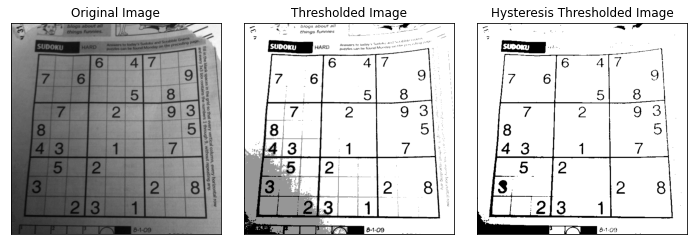

In [9]:
# Load an image as grayscale
image = cv.imread('../data/sudoku.png', 0)

# Double threshold the image
image_thresholded = threshold(image, 50, 75)

# Apply hysteresis thresholding to the double thresholded image
image_hysteresis = hysteresis(image_thresholded)

# Plot the original- double-thresholded- & the hysteresis threshodled images
plt.figure(figsize=(10,10))

plt.subplot(131), plt.imshow(image, cmap='gray'),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(image_thresholded, cmap='gray'),
plt.title("Thresholded Image"), plt.xticks([]), plt.yticks([])

plt.subplot(133), plt.imshow(image_hysteresis, cmap='gray'),
plt.title("Hysteresis Thresholded Image"), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=2.0)
plt.show()